In this Notebook, we will Calculate the Portfolio Optimization using Harry Markowitz's Mean Variance Framework that will be served as a benchmark the DRL Agents will be used to be competed against.

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from modules.benchmarks import MultiPeriodMeanVariance
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
import json
sns.set()

In [3]:
config_file_name = "config.json"
with open(config_file_name, "r") as jsonfile:
    config_data = json.load(jsonfile)

In [4]:
djia = config_data["tickers"]["America"]["DJIA"]
NUM_ASSETS = len(djia)
len(djia)

30

In [5]:
start_date = config_data["timeframe"]["djia"]["start_date"]
end_date = config_data["timeframe"]["djia"]["end_date"]
data_interval = config_data["data_interval"]
test_ratio = config_data["train_test_ratio"]
random_seed = config_data["random_state_seed"]

In [6]:
dataset = yf.download(djia, 
                      start=start_date, 
                      end=end_date,
                      interval=data_interval)['Adj Close']
dataset.to_csv("data/raw/djia_stocks_price.csv")
dataset_price_change = dataset.pct_change().fillna(0)
dataset_return = dataset/dataset.shift(1).fillna(1)

[*********************100%%**********************]  30 of 30 completed


In [7]:
_, test_df = train_test_split(dataset_price_change, test_size=test_ratio, shuffle=False, random_state=random_seed)
len(test_df)

96

In [8]:
lookback_window = config_data["lookback_window"] # W
multi_step_horizon = config_data["multi_step_horizon"] # T
lookback_window, multi_step_horizon

(24, 3)

In [9]:
test_df_cumulative_return = dataset_return.loc[test_df.index,:]

In [10]:
X_test = []
for i in range(len(test_df.values)-lookback_window):
    Sigmas = []
    mu = []
    for j in range(multi_step_horizon):
        cov_matrix_j = test_df.iloc[i+j:i+j+lookback_window-multi_step_horizon].cov().values
        mu_j = test_df.iloc[i+j:i+j+lookback_window-multi_step_horizon].mean(0).values
        Sigmas.append(cov_matrix_j)
        mu.append(mu_j)
    hist = test_df_cumulative_return.iloc[i:i+lookback_window]
    pred = test_df_cumulative_return.iloc[i+lookback_window:i+lookback_window+multi_step_horizon]
    X_test.append([hist, np.stack(mu), np.stack(Sigmas), pred])

len(X_test)

72

In [11]:
mean_variance_mpo = MultiPeriodMeanVariance(
    num_assets=NUM_ASSETS,
    multi_period_step=multi_step_horizon,
    min_individual_allocation=0.001,
    max_individual_allocation=0.4,
    risk_aversion_coefficient=0.5,
    trade_cost=0.0025,
    holding_cost=0
)

In [12]:
result_mv = []
for hist, mu, Sigma, pred in X_test:
   if len(pred) < multi_step_horizon:
      continue
   mv_opt_weights = mean_variance_mpo(mu, Sigma)
   portfolio_value = (mv_opt_weights*pred).sum(1).prod()
   result_mv.append(portfolio_value)

In [13]:
result_mv = pd.Series(result_mv, index=test_df_cumulative_return[-len(result_mv):].index)
result_mv = result_mv.pct_change().fillna(0).cumsum()

In [14]:
dji_etf_ticker = "^DJI"
dji_index = yf.download(dji_etf_ticker, 
                        start=start_date, 
                        end=end_date,
                        interval=data_interval)['Adj Close']
dji_index = dji_index.pct_change().fillna(0)

[*********************100%%**********************]  1 of 1 completed


In [15]:
dji_index = dji_index[result_mv.index]
dji_index = np.cumsum(dji_index)

In [16]:
result_mv += 1
dji_index += 1

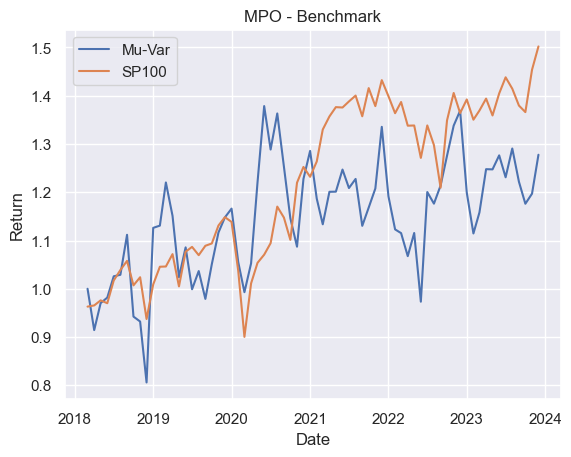

In [17]:
plt.plot(result_mv.index, result_mv, label='Mu-Var')
plt.plot(dji_index.index, dji_index, label='SP100')
plt.title('Out-of-Sample Test')
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.title("MPO - Benchmark")
plt.show()

Persisting the Portfolio Results

In [19]:
result_mv.name = "MV"
dji_index.name = "DJIA"
output_filename = "performances_djia"

In [20]:
save_df = pd.DataFrame()
save_df["SP100"] = dji_index
save_df["MV"] = result_mv

In [21]:
save_df.to_csv(f"data/processed/{output_filename}.csv")